## 02.ARIMA

- Realizado por: 
  Francisco del Val Yague, Alejandro García Girón y Laura Martínez González de Aledo

- Emails: 
  *francisco.delval@cunef.edu, a.garciagiron@cunef.edu y l.martinezg@cunef.edu*
  
Colegio Universitario de Estudios Financieros. CUNEF

In [43]:
# LIBRERIAS

# Manipulacion del DataFrame
import pandas as pd
import numpy as np

# Series Temporales
from sklearn.model_selection import train_test_split
from sklearn import model_selection
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from pmdarima.arima import auto_arima
import itertools

# Metricas
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

# Graficos
%matplotlib inline
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import seaborn as sbn
from pylab import rcParams # seasonal_decompose

# Warnings
import warnings;
warnings.filterwarnings('ignore')

# Sin puntos suspensivos
pd.options.display.max_columns = None 
pd.options.display.max_rows = None 

In [77]:
#Cargamos la base de datos
consumo_energia = pd.read_csv("../data/02_intermediate/demanda_energia_total.csv")

In [78]:
#Visualizamos el encabezado
consumo_energia.head()

,time,demanda_energia
0,2016-01-01,515581.473
1,2016-01-02,578184.270
2,2016-01-03,584378.725
3,2016-01-04,666565.106
4,2016-01-05,663020.147


In [79]:
#Visualizamos el final de la base de datos
consumo_energia.tail()

,time,demanda_energia
1819,2020-12-24,608801.8
1820,2020-12-25,540441.9
1821,2020-12-26,605654.0
1822,2020-12-27,611892.0
1823,2020-12-28,670801.3


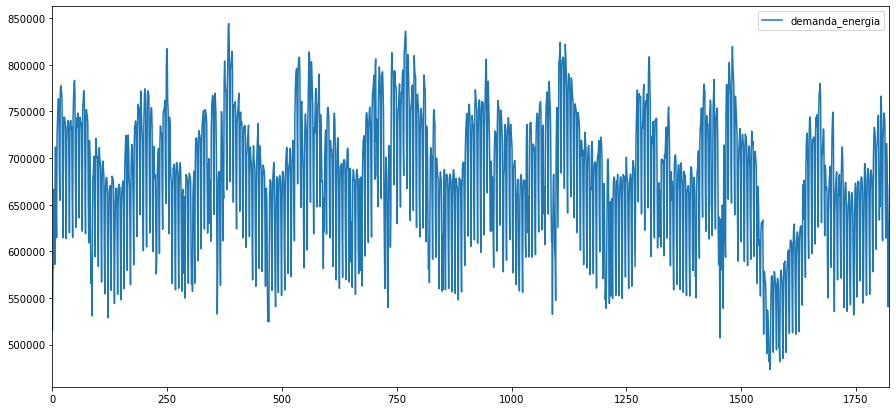

In [80]:
#A priori, se observa que con las temperaturas mas altas se consume mas energía
consumo_energia.plot(figsize=(15,7))
plt.show()

### Modelo Arima

Modelo estadístico que utiliza variaciones y regresiones de datos estadísticos con el fin de encontrar patrones para una predicción hacia el futuro. Se trata de un modelo dinámico de series temporales, es decir, las estimaciones futuras vienen explicadas por los datos del pasado y no por variables independientes.

In [81]:
dates = pd.date_range(start='2016-01-01', freq='MS', periods=len(consumo_energia))
dates[0:60]

DatetimeIndex(['2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
      

In [82]:
consumo_energia.set_index(dates,inplace=True)
consumo_energia.drop('time',axis=1,inplace=True)

#### Dividimos nuestra base de datos

In [83]:
train = (consumo_energia[consumo_energia.index < '2018-06-01'])
test = (consumo_energia[consumo_energia.index >= '2018-06-01'])

In [84]:
# Define the p, d and q parameters to take any value between 0 and 2
p = range(0,8)
d = range(0,2)
q = range(0,1)

In [85]:
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

In [86]:
best_aic = np.inf
best_pdq = None
temp_model = None
for param in pdq:   
    temp_model = ARIMA(train,order=param)
    results = temp_model.fit()
    if results.aic < best_aic:
        best_aic = results.aic
        best_pdq = param 
print("Best ARIMA {} model - AIC:{}".format(best_pdq,best_aic))

Best ARIMA (7, 1, 0) model - AIC:695.3707663258837


### Ajustamos el modelo

In [87]:
# using the best parameter in the model
model = ARIMA(train,order=(7,1,0))
model_fit = model.fit()

In [88]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:      D.demanda_energia   No. Observations:                   28
Model:                 ARIMA(7, 1, 0)   Log Likelihood                -338.685
Method:                       css-mle   S.D. of innovations          40338.623
Date:                Fri, 15 Jan 2021   AIC                            695.371
Time:                        11:05:57   BIC                            707.361
Sample:                    02-01-2016   HQIC                           699.036
                         - 05-01-2018                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    6810.3591   5544.311      1.228      0.219   -4056.290    1.77e+04
ar.L1.D.demanda_energia    -0.1873      0.183     -1.025      0.305      -0.545       0.171
ar.L2.D.demanda_energia    -0.2362      0.203     -1.162      0.245      -0.635       0.162
ar.L3.D.demanda_energia    -0.2178      0.198     -1.101      0.271      -0.606       0.170
ar.L4.D.demanda_energia    -0.0790      0.212     -0.373      0.709      -0.495       0.337
ar.L5.D.demanda_energia    -0.1293      0.184     -0.702      0.483      -0.490       0.232
ar.L6.D.demanda_energia    -0.1199      0.204     -0.588      0.557      -0.520       0.280
ar.L7.D.demanda_energia     0.5580      0.205      2.717      0.007       0.155       0.961
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9652           -0.4473j            1.0638           -0.4309
AR.2           -0.9652           +0.4473j            1.0638            0.4309
AR.3           -0.2113           -1.0215j            1.0431           -0.2825
AR.4           -0.2113           +1.0215j            1.0431            0.2825
AR.5            0.6382           -0.8482j            1.0615           -0.1473
AR.6            0.6382           +0.8482j            1.0615            0.1473
AR.7            1.2916           -0.0000j            1.2916           -0.0000
-----------------------------------------------------------------------------
"""

### Prediccion

In [89]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

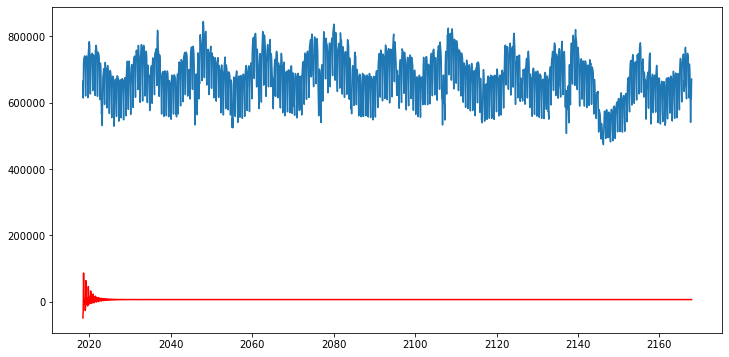

In [90]:
# plot results
plt.figure(figsize=(12,6))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

### Evaluación del modelo:

In [91]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test, predictions))
rmse = round(rmse, 3)

In [92]:
# Mean Absolute Percentage Error
abs_error = np.abs(test['demanda_energia']-predictions)
actual = test['demanda_energia']
mape = np.round(np.mean(np.abs(abs_error/actual)),3)

In [96]:
resultsDf = pd.DataFrame({'Method':['ARIMA'], 'MAPE': [mape], 'RMSE': [rmse]})
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
resultsDf

,Method,RMSE,MAPE
0,ARIMA,675985.345,0.99


El error cuadrático medio (RMSE) es la desviación estándar de los residuos ( errores de predicción ). Los residuos son una medida de qué tan lejos están los puntos de datos de la línea de regresión; RMSE es una medida de la dispersión de estos residuos. En otras palabras, le dice qué tan concentrados están los datos alrededor de la línea de mejor ajuste. 


El error de porcentaje absoluto medio (MAPE), también conocido como desviación de porcentaje absoluto medio (MAPD), es una medida de precisión de predicción de un método de pronóstico en estadística, por ejemplo, en estimación de tendencias, también utilizado como función de pérdida para problemas de regresión en Machine Learning.

### Referencias:

* _https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd_